In [5]:
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob
import pandas
import re
import string
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
df_ExtractedTweets=pandas.DataFrame({'tweets':[]})
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score
from sklearn import tree
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Embedding,
    SpatialDropout1D,
)
from tensorflow.keras.models import (
    Model,
    load_model,
    Sequential
)
from tensorflow.keras.callbacks import ModelCheckpoint
from ast import literal_eval
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
consumer_key = "XXXXXXX" 
consumer_secret = "XXXXXX"
access_key = "XXXXXXXX"
access_secret = "XXXXXXXX"


def get_tweet_sentiment(tweettext): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweettext) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else:
            return 'negative'
  
# Function to extract tweets 
def get_tweets(username): 
        # Authorization to consumer key and consumer secret 
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
        # Access to user's access key and access secret 
        auth.set_access_token(access_key, access_secret) 
        # Calling api 
        api = tweepy.API(auth) 
        tmp=[]
        # 200 tweets to be extracted 
        number_of_tweets=200
        tweets = api.search(q=username,count=number_of_tweets,lang='en')  
        df_ExtractedTweets['tweets']= [tweet.text for tweet in tweets]
  
# Driver code 
if __name__ == '__main__': 
  
    # Here goes the twitter handle for the user 
    # whose tweets are to be extracted. 
    get_tweets("@amazonIN iPhone -filter:retweets AND -filter:replies")

In [0]:
df_ExtractedTweets.to_csv('ExtractedTweets.csv')

After combining all the tweets into one dataset

In [0]:
df_AllTweets=pd.read_csv('AllTweets.csv',encoding='latin-1')

In [9]:
df_AllTweets.head()

,tweets
0,#QuizTimeMorningsWithAmazon I am eligible to W...
1,"Thanks @amazonIN for amazing quiz and prize , ..."
2,Way for Apple iPhone XS11/02/2020 @amazonIN #D...
3,#QuizTimeMorningsWithAmazon I am eligible to w...
4,#quiztimemoringswithamazon Yes i would like to...


In [0]:
TAG_CLEANING_RE = "@\S+"
# Remove @tags
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: x.lower())

# Remove numbers
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
df_AllTweets['tweets']  = df_AllTweets['tweets'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: x.strip())

In [0]:
df_AllTweets['sentiment']= [get_tweet_sentiment(row['tweets']) for index,row in df_AllTweets.iterrows()]

In [12]:
df_AllTweets.head()

,tweets,sentiment
0,quiztimemorningswithamazon i am eligible to wi...,positive
1,thanks for amazing quiz and prize stay tuned w...,positive
2,way for apple iphone xs dailyquiz quiztimemorn...,neutral
3,quiztimemorningswithamazon i am eligible to wi...,positive
4,quiztimemoringswithamazon yes i would like to ...,positive


In [0]:
for i in range(len(df_AllTweets['sentiment'])):
  if df_AllTweets['sentiment'][i]=='positive':
    df_AllTweets['sentiment'][i]=1
  elif df_AllTweets['sentiment'][i]=='neutral':
    df_AllTweets['sentiment'][i]=0
  else:
    df_AllTweets['sentiment'][i]=2

In [14]:
df_AllTweets.head()

,tweets,sentiment
0,quiztimemorningswithamazon i am eligible to wi...,1
1,thanks for amazing quiz and prize stay tuned w...,1
2,way for apple iphone xs dailyquiz quiztimemorn...,0
3,quiztimemorningswithamazon i am eligible to wi...,1
4,quiztimemoringswithamazon yes i would like to ...,1


In [0]:
# Tokenize into words
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: word_tokenize(x))

# Remove non alphabetic tokens
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
stop_words = set(stopwords.words('english'))
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: [w for w in x if not w in stop_words])

# Word Lemmatization
lem = WordNetLemmatizer()
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
df_AllTweets['tweets'] = df_AllTweets['tweets'].map(lambda x: ' '.join(x))

In [0]:
comment_words = ' '
for val in df_AllTweets.tweets: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
      comment_words = comment_words + words + ' '

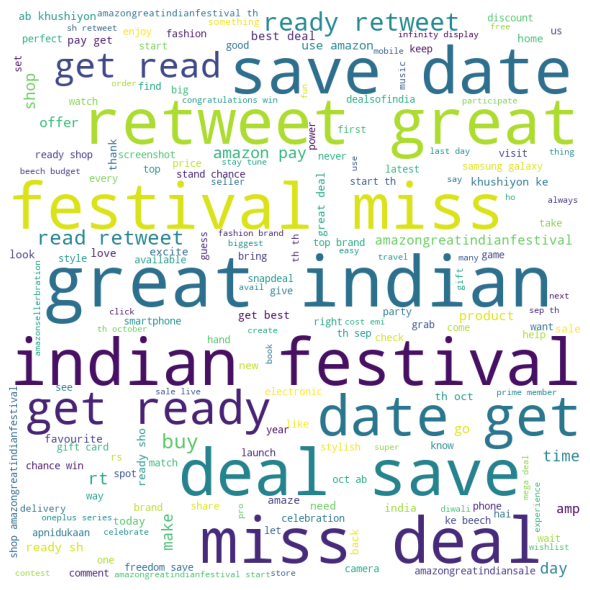

In [17]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words=stop_words)
tfidf_vectorizer.fit(df_AllTweets['tweets'])
tfidf = tfidf_vectorizer.transform(df_AllTweets['tweets'])
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words=stop_words)
bow = bow_vectorizer.fit_transform(df_AllTweets['tweets'])

In [19]:
df_AllTweets.describe()

,tweets,sentiment
count,4120,4120
unique,3544,3
top,retweet great indian festival miss deal save d...,1
freq,260,3082


In [0]:
train_bow = bow[:4120,:]
test_bow = bow[4120:,:]
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df_AllTweets['sentiment'], random_state=42, test_size=0.3)
train_tfidf = tfidf[:4120,:]
test_tfidf = tfidf[4120:,:]
ytrain=ytrain.astype('int')
yvalid=yvalid.astype('int')
xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [21]:
lreg=LogisticRegression()
lreg.fit(xtrain_tfidf, ytrain)
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
print("Logistic Regression with TF-IDF f1: {}".format(f1_score(yvalid, prediction_int,average='micro')))

Logistic Regression with TF-IDF f1: 0.8446601941747571


In [22]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(xtrain_tfidf, ytrain)  
y_pred = clf.predict(xvalid_tfidf)
print("Decision Tree Classifier with TF-IDF f1: {}".format(f1_score(yvalid, y_pred,average='micro')))

Decision Tree Classifier with TF-IDF f1: 0.9223300970873787
